In [104]:
%run geometria.ipynb
import random
from math import sqrt

In [105]:
Tolerance = 10e-12

Funkcje pomocnicze

In [287]:
# sprawdzanie, po której stronie odcinka leży punkt - funkcje pomocnicze
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - c[0] * b[1] - b[0] * a[1] - a[0] * c[1]

def orient(a, b, c):
    determinant = det(a, b, c)
    if determinant > Tolerance: # lewa strona
        return 1
    elif determinant < -Tolerance: # prawa strona
        return -1
    else: # współliniowe
        return 0
    
def find_left(a, b, points): # punkty leżące po lewej stronie odcinka utworzonego przez punkty a i b
    left = []
    for point in points:
        o = orient(a, b, point)
        if o == 1:
            left.append(point)
    return left

def find_right(a,b,points):  # punkty leżące po prawej stronie odcinka utworzonego przez punkty a i b
    right = []
    for point in points:
        o = orient(a, b, point)
        if o == -1:
            right.append(point)
    return right

# wyszukiwanie najdalej leżącego punktu

def find_segment(a,b): # równanie prostej, wyszukiwanie współczynników A i C dla równania postaci y = Ax + C
    A = (a[1] - b[1])/(a[0] - b[0])
    C = a[1] - A * a[0]
    return A, C

def find_distance(a,b,c): # odległość punktu c od prostej utworzonej przez punkty a i b
    A, C = find_segment(a,b) # B = -1 bo przenoszę y w równaniu: y = Ax + C -> 0 = Ax -y + C
    B = -1
    distance = abs(A*c[0] + B*c[1] + C)/ sqrt(A**2 + B**2)
    return distance

def find_furthest(a, b, points):
    result, distance = None, 0
    for point in points:
        if result is None or find_distance(a,b,point) > distance:
            distance = find_distance(a,b,point)
            result = point
    return result

# do wizualizacji

def add_scene(result_hull, points, scenes):
    n = len(result_hull)
    lines = [(result_hull[i], result_hull[(i + 1) % n]) for i in range(n)]
    scenes.append(Scene([PointsCollection(points, color='hotpink'),
                         PointsCollection(result_hull, color='green')],
                    [LinesCollection(lines, color='lime')]))

Główny algorytm

In [306]:
def recursion(a, b, points_sorted, scenes, points):
    if points_sorted == [] or a is None or b is None: # warunek końca rekurencji - nie ma punktów 
        return []
    
    c = find_furthest(a, b, points_sorted) # szukamy najdalszego punktu
    if c is None: return []
    points_sorted.remove(c)
    
    # przeszukujemy punkty które znajdują się na zewnątrz aktualnej otoczki
    points1 = find_left(a, c, points_sorted)
    points2 = find_right(b, c, points_sorted)

    hull = [a] + recursion(a, c, points1, scenes,points) + [c] + recursion(c, b, points2, scenes,points) + [b]
    add_scene(hull, points, scenes)
    return hull


In [307]:
def algo(points, result_hull, scenes):   
    if len(points) < 3: return points
    points_sorted = sorted(points, key = lambda x: (x[0], x[1]))
    
    # dwa skrajne punkty A i B - jeden o najmniejszej odciętej, drugi o największej
    a, b = points_sorted[0], points_sorted[-1]
    points_sorted.remove(a)
    points_sorted.remove(b)
    
    left, right = find_left(a, b, points_sorted), find_right(a, b, points_sorted)
    result_hull += recursion(a, b, left, scenes, points_sorted) + recursion(b, a, right, scenes, points_sorted)
    
    return result_hull

In [308]:
def QuickHull(points):
    scenes = []
    result_hull = []
    points_hull = []
    scenes.append(Scene([PointsCollection(points, color='hotpink')]))
    result_hull = algo(points, result_hull, scenes)
    add_scene(result_hull, points, scenes)
    return scenes

Testowanie

<IPython.core.display.Javascript object>


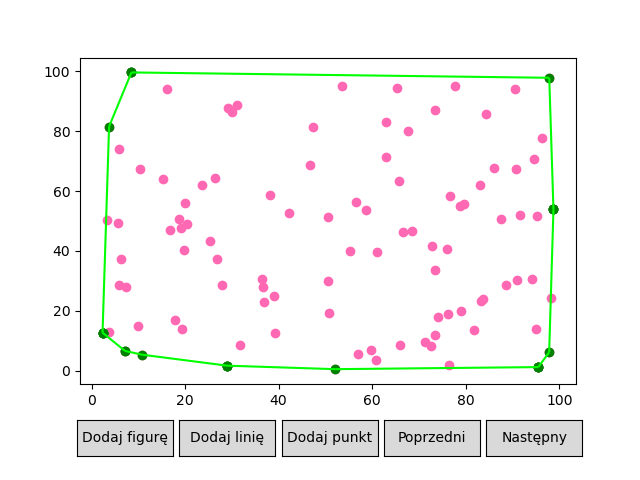

In [309]:
def randoms(n, range_x, range_y):
    points = []
    for _ in range(n):
        x = random.uniform(range_x[0], range_x[1])
        y = random.uniform(range_y[0], range_y[1])
        points.append((x, y))

    return points

data = randoms(100, [0, 100], [0, 100])
scenes = QuickHull(data)
plot = Plot(scenes=scenes)
plot.draw()